# Getting to Know the Twitter API

Twitter is a goldmine for unstructured text data. The purpose of this notebook is to familiarize myself with how to associate with the Twitter API as well as practice natrual language processing techniques. 

In [1]:
import json
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import tweepy

In [2]:
'''
OAuth Process
With keys, tokens, setting up instance of API
Adapted from https://medium.freecodecamp.org/basic-data-analysis-on-twitter-with-python-251c2a85062e
'''

def load_api():
    # Credentials
    consumer_key = ''
    consumer_secret = ''
    access_token = ''
    access_token_secret = ''

    # Authorization
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    return tweepy.API(auth)

In [3]:
# Test if truly authenticated
# Create user object from API
api = load_api()
user = api.me()
print (user.name)

Laura Lai


## Mining the Tweets and Making a Dataframe

I'll be mining a small number of tweets from a specific user to see how I can manipulate the text and what analysis I can perform. The Twitter API status objects are very well organized into relevant categorical data.

In [4]:
'''
Get the Tweets
'''

def grab_tweets(handle, limit=100):
    tweets = pd.DataFrame(columns=['created_at', 'user', 'tweet_id', 'text', 'retweet_count'])

    for status in tweepy.Cursor(api.user_timeline, id=handle, include_rts=False, exclude_replies=True).items(limit):
        tweets = tweets.append({'created_at' : status.created_at, 'user' : status.user.name, 'tweet_id' : status.id, \
                                'text' : status.text, 'retweet_count' : status.retweet_count}, ignore_index=True)
    return tweets

In [5]:
trump_tweets = grab_tweets('realDonaldTrump', 500)

## Sentiment Analysis with TextBlob

TextBlob is a library used to processing text data. It is a powerful tool that can tag parts of speech, extract noun phrases, and analyze sentiment among others. I want to perform a simple correlation between sentiment and retweet count of this user's text. 

The sentiment analysis provides two values: polarity [-1.0, 1.0] and subjectivity [0.0, 1.0].

In [6]:
'''
Sentiment Analysis with TextBlob
Adapted from https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/
'''
from textblob import TextBlob

# Add sentiment scores to dataframe
trump_tweets['polarity'] = trump_tweets['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
trump_tweets['subjectivity'] = trump_tweets['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [7]:
trump_tweets.head()

,created_at,user,tweet_id,text,retweet_count,polarity,subjectivity
0,2018-10-15 15:45:43,Donald J. Trump,1051861686842474496,Just arrived in Florida. Also thinking about o...,8518,0.65,0.625000
1,2018-10-15 13:48:13,Donald J. Trump,1051832118165139458,On our way to Florida and Georgia!,7062,0.00,0.000000
2,2018-10-15 12:37:05,Donald J. Trump,1051814214212485120,Just spoke to the King of Saudi Arabia who den...,16624,0.00,0.000000
3,2018-10-15 12:25:13,Donald J. Trump,1051811228362919938,Will be leaving for Florida and Georgia with t...,9537,0.25,0.333333
4,2018-10-15 12:11:29,Donald J. Trump,1051807774894624768,The crowds at my Rallies are far bigger than t...,19307,0.05,0.750000


In [8]:
trump_tweets.describe()

,polarity,subjectivity
count,500.000000,500.000000
mean,0.205422,0.416831
std,0.350403,0.332894
min,-1.000000,0.000000
25%,0.000000,0.000000
50%,0.075066,0.475000
75%,0.460985,0.691111
max,1.000000,1.000000


Text(0,0.5,'Average Polarity')

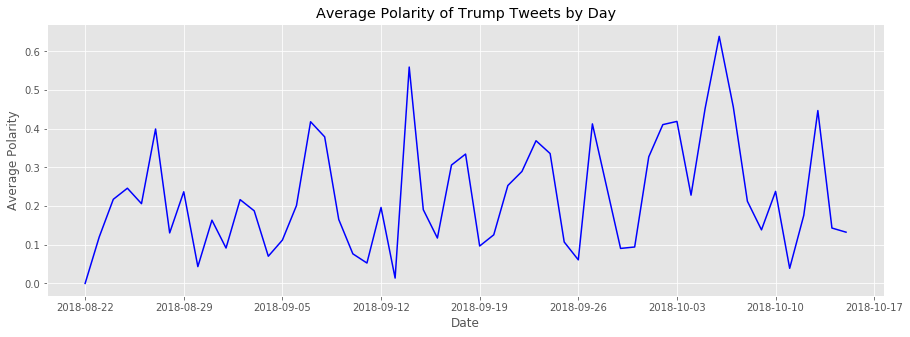

In [10]:
'''
Visualizing Polarity by Day
TODO: 
    - Highlight max and min values
    - Try to overlap average polarity with all polarity chart
'''
import datetime

trump_tweets['date'] = trump_tweets['created_at'].dt.floor('d')

polarity_df = trump_tweets[['date', 'polarity']]
polarity_df = polarity_df.groupby(by=['date'], as_index=False).mean()

plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(15,5))
ax.plot_date(x=polarity_df['date'], y=polarity_df['polarity'], fmt='b-')
plt.title('Average Polarity of Trump Tweets by Day')
plt.xlabel('Date')
plt.ylabel('Average Polarity')

Text(0,0.5,'Average Polarity')

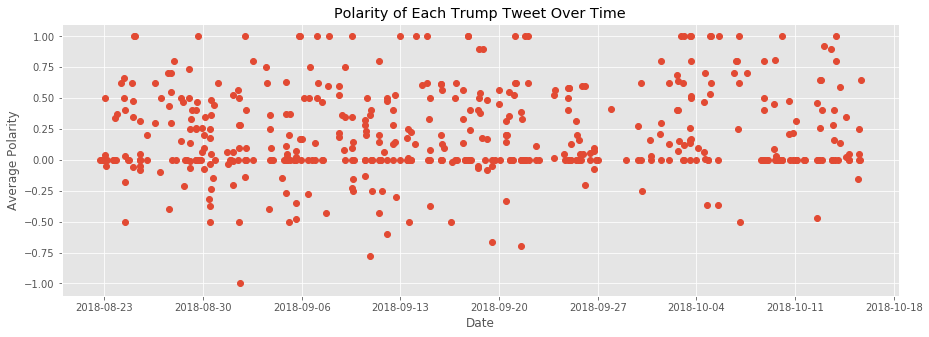

In [13]:
'''
Plotting All Polarity
'''
all_polarity = trump_tweets[['created_at', 'polarity']]
fig, ax = plt.subplots(figsize=(15,5))
ax.plot_date(x=all_polarity['created_at'], y=all_polarity['polarity'])
plt.title('Polarity of Each Trump Tweet Over Time')
plt.xlabel('Date')
plt.ylabel('Average Polarity')

## Vectorizing, Cleaning, Analyzing

Looking at the content of the tweets, I'm curious to find which words are used the most in the tweets and how that corresponds to the number of retweets.

In [15]:
# Example of tweet text
trump_tweets.text[0]

'Just arrived in Florida. Also thinking about our GREAT Alabama farmers and our many friends in North and South Caro… https://t.co/yJ7YKqClFn'

In [19]:
'''
Clean the Tweet Text
'''
import re

# Clean out URLs
# TODO: Clean hashtags and @mentions
trump_tweets['clean_tweets'] = trump_tweets['text'].apply(lambda x: re.sub('https://[A-Za-z0-9./]+', '', x))
trump_tweets.clean_tweets[0]

'Just arrived in Florida. Also thinking about our GREAT Alabama farmers and our many friends in North and South Caro… '

In [20]:
'''
Vectorize and Clean
'''

from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

# Tokenize - Separate each tweet into a list of individual words only if they start with a letter
trump_tweets['tokens'] = trump_tweets['clean_tweets'].apply(lambda tweet: [word for word in nltk.word_tokenize(tweet) \
                                                                           if re.search('^[a-zA-Z]+', word)])
trump_tweets.tokens[1]

# Remove stopwords
stopwords = nltk.corpus.stopwords.words('english')

In [22]:
vect = TfidfVectorizer(stop_words='english', max_features=30)
fit_tweets = vect.fit_transform(trump_tweets['clean_tweets']).toarray()
tweet_features = vect.get_feature_names()
tweet_features

['america',
 'amp',
 'country',
 'democrats',
 'doing',
 'don',
 'fbi',
 'florida',
 'great',
 'honor',
 'job',
 'just',
 'kavanaugh',
 'love',
 'make',
 'new',
 'news',
 'people',
 'president',
 'really',
 'state',
 'thank',
 'time',
 'today',
 'tonight',
 'trade',
 'trump',
 'united',
 'vote',
 'years']